In [1]:
import time

import tensorflow as tf
import matplotlib.pyplot as plt

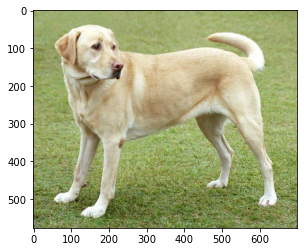

In [2]:
img_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
encoded_img = tf.io.read_file(img_path)
img = tf.image.decode_image(encoded_img)
plt.imshow(img)

In [18]:
class DeepDream(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        inception_v3 = tf.keras.applications.InceptionV3(include_top=False, 
                                                         weights='imagenet')
        inputs = [inception_v3.inputs]
        outputs = [layer.output for layer in inception_v3.layers 
                   if self._is_interested_layer(layer)]
        self.model = tf.keras.Model(inputs, outputs)
        
        self.lr = .01
        
    def _is_interested_layer(self, layer):
        if layer.name in ('mixed3', 'mixed5'):
            return True
        
    def call(self, img):
        loss = 0
        with tf.GradientTape() as tape:
            tape.watch(img)
            layer_activations = self.model(img)
            loss = tf.reduce_sum([tf.reduce_mean(act) for act in layer_activations])

        grads = tape.gradient(loss, img)
        grads /= tf.math.reduce_std(grads) + 1e-8 # 標準化
        img = img + self.lr * grads
        img = tf.clip_by_value(img, -1, 1)
        return img

In [27]:
deep_dreem = DeepDream()

# 使圖片符合輸入格式
dream_img = tf.expand_dims(img, axis=0)
dream_img = tf.cast(dream_img, tf.float32)
dream_img = tf.keras.applications.inception_v3.preprocess_input(dream_img) # [0, 255] -> [0, 1]

In [28]:
steps = 50

octave_scale = 1.3
base_shape = tf.cast(tf.shape(dream_img)[1:-1], tf.float32) # 只需要取長寬, 不需要批量數和通道數

for n in range(-2, 3): # 縮放的尺度
    new_shape = tf.cast((octave_scale ** n) * base_shape, tf.int32)
    for step in range(steps):
        start = time.time()

        # 以各種尺寸訓練, 才有大小不一的幻象
        dream_img = tf.image.resize(dream_img, new_shape)
        dream_img = deep_dreem(dream_img)

        end = time.time()
        duration = end - start
        print(f"n: {n}, step: {step}, duration: {duration:.1f}s")
        

dream_img = tf.image.resize(dream_img, tf.cast(base_shape, tf.int32)) # 復原尺寸

n: -2, step: 0, duration: 0.6s
n: -2, step: 1, duration: 0.6s
n: -2, step: 2, duration: 0.6s
n: -2, step: 3, duration: 0.6s
n: -2, step: 4, duration: 0.6s
n: -2, step: 5, duration: 0.6s
n: -2, step: 6, duration: 0.6s
n: -2, step: 7, duration: 0.6s
n: -2, step: 8, duration: 0.6s
n: -2, step: 9, duration: 0.6s
n: -2, step: 10, duration: 0.6s
n: -2, step: 11, duration: 0.6s
n: -2, step: 12, duration: 0.6s
n: -2, step: 13, duration: 0.6s
n: -2, step: 14, duration: 0.6s
n: -2, step: 15, duration: 0.6s
n: -2, step: 16, duration: 0.6s
n: -2, step: 17, duration: 0.5s
n: -2, step: 18, duration: 0.6s
n: -2, step: 19, duration: 0.6s
n: -2, step: 20, duration: 0.6s
n: -2, step: 21, duration: 0.6s
n: -2, step: 22, duration: 0.6s
n: -2, step: 23, duration: 0.6s
n: -2, step: 24, duration: 0.5s
n: -2, step: 25, duration: 0.6s
n: -2, step: 26, duration: 0.6s
n: -2, step: 27, duration: 0.5s
n: -2, step: 28, duration: 0.5s
n: -2, step: 29, duration: 0.6s
n: -2, step: 30, duration: 0.6s
n: -2, step: 31, d

In [29]:
# 使圖片符合輸出格式
dream_img = tf.squeeze(dream_img)
dream_img = tf.cast(dream_img, tf.float32)
dream_img = 127.5 * dream_img + 127.5 # [-1, 1] -> [0, 255]
dream_img = tf.cast(dream_img, tf.uint8)

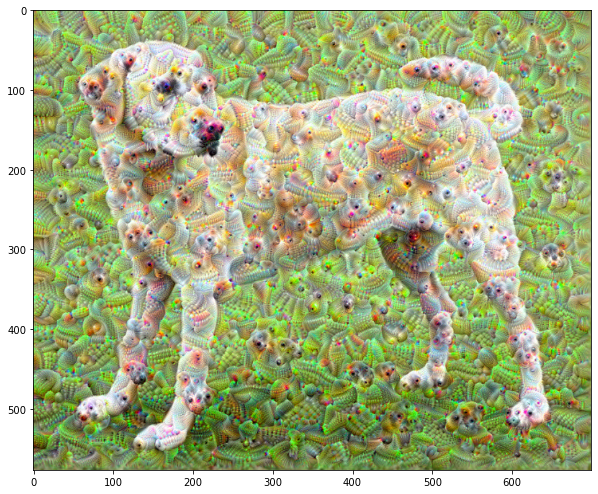

In [30]:
plt.figure(figsize=(10, 10))
plt.imshow(dream_img)